# Семинар по обучению полносвязных нейросетей в Pytorch

На этом семинаре мы будем обучать полносвзяную нейроную сеть на данных MNIST - изображениях рукописных цифр.

Мы будем использовать библиотеку Pytorch - это одна из двух наиболее популярных и часто используемых библиотек для обучения нейронных сетей.

### Загрузка данных

In [81]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data

In [58]:
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с данными MNIST: это набор из 60000 изображений цифр размером 28x28. 

В Pytorch есть своя обертка, позволяющая скачивать MNIST автоматически, но нам будет удобнее скачать его самостоятельно.

In [59]:
from util import load_mnist

In [60]:
X_train, y_train, X_test, y_test = load_mnist()

Данные уже разделены на обучающую и тестовую части!

Посмотрим на форму всех загруженных переменных:

In [61]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 1, 28, 28), (10000, 1, 28, 28), (60000,), (10000,))

Визуализируем несколько объектов обучающей выборки:

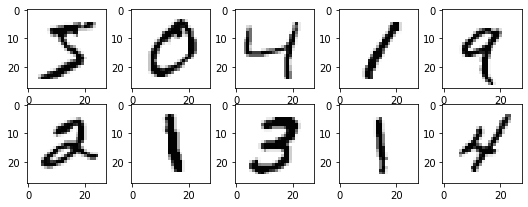

In [62]:
plt.figure(figsize=(9, 3.2))
for im in range(10):
    plt.subplot(2, 5, im+1)
    plt.imshow(X_train[im, 0], cmap="Greys")

А вот так выглядят данные в виде таблицы объекты-признаки:

In [63]:
X_train[:2]

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)

### Подготовка данных

При обучении нейронной сети нам понадобится генерировать мини-батчи объектов. Для этого мы воспользуемся специальными инструментами Pytorch. Мы сократим набор данных для обучения, чтобы оно шло быстрее:

In [86]:
def get_loader(X, y, batch_size=64):
    train = torch.utils.data.TensorDataset(torch.from_numpy(X).\
                                                reshape(-1, 28*28).float(), 
                                           torch.from_numpy(y).long())
    train_loader = torch.utils.data.DataLoader(train, 
                                               batch_size=batch_size)
    return train_loader

train_loader = get_loader(X_train[:15000], y_train[:15000])
test_loader = get_loader(X_train[15000:30000], y_train[15000:30000])

train_loader_full = get_loader(X_train, y_train) 
test_loader = get_loader(X_test, y_test)

### Сборка нейронной сети

Нейронные сети обычно "собирают" из готовых слоев. В методе \_\_init\_\_ нужно указать все слои, которые будут использованы, а в методе forward нужно указать, как выполняется _проход вперед_. Иными словами, какие преобразования нужно выполнить, чтобы получить предсказания.

Составим нейронную сеть из трех полносвязных слоев с нелинейностью ReLU:

In [65]:
class OurFirstNet(nn.Module):
    def __init__(self, k=1):
        super(OurFirstNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        l1 = self.fc1(x)
        a1 = self.relu(l1)
        l2 = self.fc2(a1)
        a2 = self.relu(l2)
        out = self.fc3(a2)
        return out

Посчитаем параметры нейросети:

In [66]:
our_model = OurFirstNet()

In [67]:
def count_parameters(model):
    return sum(param.data.numpy().size for param \
               in model.parameters() if param.requires_grad)

count_parameters(our_model)

105214

### Обучение нейросети

Определим функционал качества (он включает слой Softmax):

In [68]:
criterion = nn.CrossEntropyLoss()

Зададим оптимизатор, реализующий стохастический градиентный спуск:

In [69]:
opt = torch.optim.SGD(our_model.parameters(), lr=0.1)

Во время обучения модели удобно контролировать качество и на обучении, и на тесте - возникает дублирующий код. Поэтому мы вынесем в отдельную функцию оценку модели, и в отдельную функцию - одну эпоху обучения (один проход по всей обучающей выборке).

In [78]:
def train_epoch(model, optimizer, train_loader, criterion):
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch) # проход вперед (выполнение предсказаий)
        
        loss = criterion(output, y_batch) # вычисление функционала качества
        loss.backward() # проход назад (вычисление градиентнов)
        optimizer.step() # шаг стохастического градиентного спуска (обновление параметров)

def evaluate_loss_acc(model, loader, criterion):
    with torch.no_grad(): # сообщаем библиотеке, что вычисление градиентов не потребуется
        cumloss, cumacc = 0, 0
        num_objects = 0
        for x_batch, y_batch in loader:
            output = model(x_batch) # проход вперед (выполнение предсказаий)
            loss = criterion(output, y_batch) # вычисление функционала качества
            pred = torch.max(output, 1)[1] # выбор предсказанных классов
            acc = torch.sum(pred == y_batch) # вычисление точности 

            cumloss += loss.item()
            cumacc += acc.item()
            num_objects += len(x_batch)
    return cumloss / num_objects, cumacc / num_objects
    
    
def train(model, opt, train_loader, test_loader, criterion, \
          n_epochs=10, print_info=True):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        train_epoch(model, opt, train_loader, criterion)
        train_loss, train_acc = evaluate_loss_acc(model, train_loader, 
                                                  criterion)
        val_loss, val_acc = evaluate_loss_acc(model, test_loader, 
                                              criterion)

        train_log.append(train_loss)
        train_acc_log.append(train_acc)

        val_log.append(val_loss)
        val_acc_log.append(val_acc)
        
        if print_info:
            print (('Эпоха [%d/%d], функц. кач. (train/test): %.4f/%.4f,'+\
               ' точность (train/test): %.4f/%.4f' )
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss, train_acc, val_acc))
            
    return train_log, train_acc_log, val_log, val_acc_log

Обучим нашу нейронную сеть:

In [71]:
### your code here
results = train(our_model, opt, train_loader, test_loader, criterion, \
      n_epochs=20)

Эпоха [1/20], функц. кач. (train/test): 0.0343/0.0344, точность (train/test): 0.2821/0.2788
Эпоха [2/20], функц. кач. (train/test): 0.0294/0.0294, точность (train/test): 0.5561/0.5564
Эпоха [3/20], функц. кач. (train/test): 0.0191/0.0191, точность (train/test): 0.7374/0.7429
Эпоха [4/20], функц. кач. (train/test): 0.0125/0.0124, точность (train/test): 0.8127/0.8190
Эпоха [5/20], функц. кач. (train/test): 0.0098/0.0096, точность (train/test): 0.8390/0.8419
Эпоха [6/20], функц. кач. (train/test): 0.0084/0.0082, точность (train/test): 0.8561/0.8581
Эпоха [7/20], функц. кач. (train/test): 0.0075/0.0074, точность (train/test): 0.8713/0.8706
Эпоха [8/20], функц. кач. (train/test): 0.0069/0.0068, точность (train/test): 0.8787/0.8778
Эпоха [9/20], функц. кач. (train/test): 0.0065/0.0064, точность (train/test): 0.8853/0.8830
Эпоха [10/20], функц. кач. (train/test): 0.0062/0.0061, точность (train/test): 0.8913/0.8869
Эпоха [11/20], функц. кач. (train/test): 0.0059/0.0059, точность (train/test): 


### Пробуем разную длину шага и размер мини-батча

У нейросетей много гиперпараметров, один из самых важных - длина шага. Этот гиперпараметр нужно подбирать индивидуально для каждой задачи. Хорошая новость - довольно часто длину шага удается подобрать, используя только обучающую выборку!

Попробуем использовать разную длину шага:

In [95]:
train_acc_history = []
val_acc_history  = []
for lr in [1e-4, 1e-3, 1e-2, 1e-1, 1]:
        # создаем новую модель
        my_nn = OurFirstNet()
        # установка длины шага
        optimizer = torch.optim.SGD(my_nn.parameters(), lr=lr)
        # обучение модели
        _, train_acc_log, _, val_acc_log = train(my_nn, 
                                                 optimizer, 
                                                 train_loader, 
                                                 test_loader,
                                                 criterion,
                                                 n_epochs=20, 
                                                 print_info=False)
        
        train_acc_history.append(train_acc_log)
        val_acc_history.append(val_acc_log)

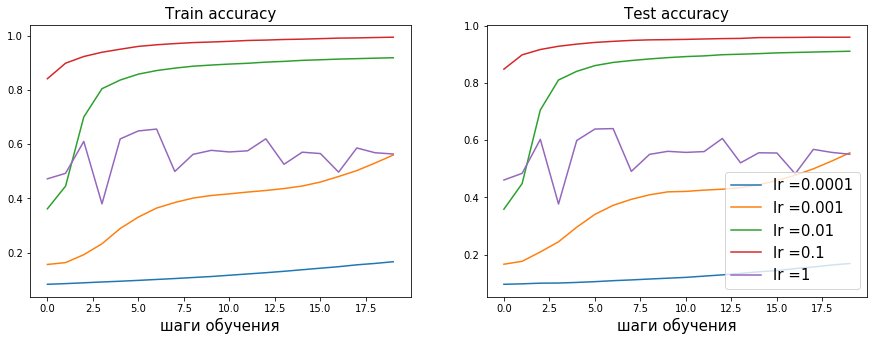

In [98]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title("Train accuracy", fontsize=15)
ax2.set_title("Test accuracy", fontsize=15)
ax1.set_xlabel("шаги обучения", fontsize=15)
ax2.set_xlabel("шаги обучения", fontsize=15)
t = 0
for lr in [1e-4, 1e-3, 1e-2, 1e-1, 1]:
        ax1.plot(train_acc_history[t], 
                 label="lr =" +str(lr))
        ax2.plot(val_acc_history[t], 
                 label="lr =" +str(lr))
        t+=1
ax2.legend(fontsize=15)       

С маленькой длиной шага алгоритм обучается слишком медленно, не успевая достичь высокого качества. Со слишком большой длиной шага алгоритм, наоборот, не сходится, то есть вообще не сможет достичь высокого качества. Нужно выбирать оптимальную длину шага.